In [12]:
import numpy as np
import torch 
import pyro
import re
import pandas as pd

import seaborn as sns
import importlib
from plotnine import *
import time
import pickle

from granch_utils import init_model_tensor, main_sim_tensor, compute_prob_tensor, init_params_tensor, num_stab_help
#importlib.reload(granch_utils)
importlib.reload(num_stab_help)
importlib.reload(init_model_tensor)
importlib.reload(main_sim_tensor)

<module 'granch_utils.main_sim_tensor' from '/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/granch_utils/main_sim_tensor.py'>

In [10]:
importlib.reload(main_sim_tensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_INFO = {
    "jitter_n": 1, 
    "total_batch_n": 1, 
    "jitter_mode": "sampling"
}

GRID_INFO = {
    "grid_mu_start": -4, "grid_mu_end": 4, "grid_mu_step": 20, 
    "grid_sigma_start": 0.001, "grid_sigma_end": 1.8, "grid_sigma_step": 20, 
    "grid_y_start": -4, "grid_y_end": 4, "grid_y_step": 20, 
    "grid_epsilon_start": 0.001, "grid_epsilon_end": 1.8, "grid_epsilon_step": 20, 
    "hypothetical_obs_grid_n": 10
}


BATCH_GRID_INFO = num_stab_help.get_batch_grid(BATCH_INFO, GRID_INFO)

PRIOR_INFO = {
    "mu_prior": 0,  
    "V_prior": 3, 
    "alpha_prior": 1, 
    "beta_prior": 2, 
    "epsilon": 0.001, "mu_epsilon": 0.001, "sd_epsilon": 4, 
    "hypothetical_obs_grid_n": 10, 
    "world_EIGs": 0.0001, "max_observation": 500
}

tensor_stimuli = num_stab_help.set_up_toy_example(0.10101012, 0.40101012)
print(tensor_stimuli)

tensor_model =  init_model_tensor.granch_model(PRIOR_INFO['max_observation'], tensor_stimuli[0])


params = init_params_tensor.granch_params(
                grid_mu =  BATCH_GRID_INFO["grid_mus"][0].to(device),
                grid_sigma = BATCH_GRID_INFO["grid_sigmas"][0].to(device),
                grid_y = BATCH_GRID_INFO["grid_ys"][0].to(device),
                grid_epsilon = BATCH_GRID_INFO["grid_epsilons"][0].to(device),
                hypothetical_obs_grid_n = PRIOR_INFO["hypothetical_obs_grid_n"], 
                mu_prior = PRIOR_INFO["mu_prior"],
                V_prior = PRIOR_INFO["V_prior"], 
                alpha_prior = PRIOR_INFO["alpha_prior"], 
                beta_prior = PRIOR_INFO["beta_prior"],
                epsilon  = PRIOR_INFO["epsilon"], 
                mu_epsilon = PRIOR_INFO["mu_epsilon"], 
                sd_epsilon = PRIOR_INFO["sd_epsilon"], 
                world_EIGs = PRIOR_INFO["world_EIGs"],
                max_observation = PRIOR_INFO["max_observation"])
        
            # add the various different cached bits
params.add_meshed_grid()
params.add_lp_mu_sigma()
params.add_y_given_mu_sigma()
params.add_lp_epsilon()
params.add_priors()

res = main_sim_tensor.granch_main_simulation(params, tensor_model, tensor_stimuli[0])
print(res.behavior)
#main_sim_tensor.granch_main_simulation(PRIOR_INFO, tensor_model, tensor_stimuli)


{'total_batch_n': 1, 'jitter_n': 1, 'grid_mus': [tensor([-1.9363,  2.8991, -3.9610, -3.2420, -2.4462,  1.7807,  0.2072, -3.2616,
        -1.4869,  0.1186,  0.3962,  3.8672, -3.5162,  1.4164,  2.5296,  0.6412,
         0.3663, -1.6951,  3.9725, -3.9300])], 'grid_sigmas': [tensor([0.3529, 0.2854, 1.2269, 1.0565, 1.2806, 1.0139, 1.4689, 0.8258, 1.4580,
        0.4396, 1.7219, 0.2581, 0.0824, 1.7945, 1.5411, 1.1404, 1.0273, 0.4329,
        1.4486, 1.2428])], 'grid_ys': [tensor([-1.8154, -3.7172, -1.5151,  2.5314, -3.5414, -3.1355,  0.7004,  1.6923,
        -1.3620, -0.9762, -2.3633, -0.1298,  1.5603, -0.7474, -1.0977, -3.0741,
         1.6197,  0.4412, -3.1256,  2.0972])], 'grid_epsilons': [tensor([0.9750, 0.9530, 1.1540, 1.6142, 0.6314, 0.4200, 0.5315, 0.2944, 0.3277,
        1.1919, 0.3502, 0.5337, 1.1788, 1.0581, 0.3044, 0.4772, 1.5075, 0.8660,
        1.6501, 1.7299])]}
[<granch_utils.init_model_tensor.granch_stimuli object at 0x10cf70190>, <granch_utils.init_model_tensor.granch_stimul

In [ ]:

folder_path = "cache_results/"
df_list = []
for file_name in os.listdir(folder_path): 
    pattern_batch_info = r"batch_(\d+)_cache_([A-Z]+)"
    #pattern_stim_spec = r"b_([\d\.]+)_d_([\d\.]+)"
    if file_name.endswith(".pickle"):    
        batch_id, stimuli = re.search(pattern_batch_info, file_name).groups()
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_pickle(file_path)
        df["batch_id"] = batch_id
        df["stimuli"] = stimuli
        df_list.append(df)

main_df = pd.concat(df_list)
main_df = main_df.dropna()

with open("cache_results/cache_summary/summary.pickle", 'wb') as f:
    pickle.dump(main_df, f)

In [5]:
importlib.reload(num_stab_help)
BATCH_INFO = {
    "jitter_n": 1, 
    "total_batch_n": 1, 
    "jitter_mode": "sampling"
}

GRID_INFO = {
    "grid_mu_start": -1, "grid_mu_end": 1, "grid_mu_step": 3, 
    "grid_sigma_start": 0.001, "grid_sigma_end": 1.8, "grid_sigma_step": 3, 
    "grid_y_start": -1, "grid_y_end": 1, "grid_y_step": 3, 
    "grid_epsilon_start": 0.001, "grid_epsilon_end": 1.8, "grid_epsilon_step": 3, 
    "hypothetical_obs_grid_n": 10
}



BATCH_GRID_INFO = num_stab_help.get_batch_grid(BATCH_INFO, GRID_INFO)

PRIOR_INFO = {
    "mu_prior": 0.001,  
    "V_prior": 0.001, 
    "alpha_prior": 1, 
    "beta_prior": 1, 
    "epsilon": 0.000001, "mu_epsilon": 0.001, "sd_epsilon": 4, 
    "hypothetical_obs_grid_n": 10, 
    "world_EIGs": 0.0001, "max_observation": 500
}

p = num_stab_help.create_prior_list(PRIOR_INFO, "epsilon", prior_val_list=[0.1, 0.001, 0.00001])
l = num_stab_help.set_up_toy_example(0.10101012, 0.60101012)
print(p)
l_small = num_stab_help.set_up_toy_example(0.10101012, 0.40101012)
l_big = num_stab_help.set_up_toy_example(0.10101012, 0.90101012)
l_small.extend(l_big)
print(len(l_small))

for STIMULI_INFO in l: 
    print(STIMULI_INFO)
    for PRIOR_INFO in p: 
        print(PRIOR_INFO)
        num_stab_help.run_all_sim(BATCH_GRID_INFO, PRIOR_INFO, STIMULI_INFO)
   
l_small = num_stab_help.set_up_toy_example(0.10101012, 0.40101012)
l_big = num_stab_help.set_up_toy_example(0.10101012, 0.90101012)
print(l_small.extend(l_big))
#for STIMULI_INFO in l: 
#    num_stab_help.run_all_sim(BATCH_GRID_INFO, PRIOR_INFO, STIMULI_INFO)



[{'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 1e-06, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}, {'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 0.1, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}, {'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 0.001, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}, {'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 1e-05, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}]
8
{'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 1e-06, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)


cache batch  0
{'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 0.1, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}
cache batch  0
{'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 0.001, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}
cache batch  0
{'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 1e-05, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}
cache batch  0
{'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 1e-06, 'mu_epsilon': 0.001, 'sd_epsilon': 4, 'hypothetical_obs_grid_n': 10, 'world_EIGs': 0.0001, 'max_observation': 500}
cache batch  0
{'mu_prior': 0.001, 'V_prior': 0.001, 'alpha_prior': 1, 'beta_prior': 1, 'epsilon': 0.1, 'mu_epsilon': 

In [17]:
embeddings = pd.read_csv("embedding_PCA.csv", header = None)


0   -3.803503
dtype: float64

# Visualization


In [3]:
import pandas as pd
import seaborn as sns
import os 
import re

folder_path = "cache_results/"
df_list = []
for file_name in os.listdir(folder_path): 
    pattern_batch_info = r"batch_(\d+)_cache_([A-Z]+)"
    #pattern_stim_spec = r"b_([\d\.]+)_d_([\d\.]+)"
    if file_name.endswith(".pickle"):   
        
        batch_id, stimuli = re.search(pattern_batch_info, file_name).groups()
        #b_val, d_val = re.search(pattern_stim_spec, file_name).groups()
        #d_val = d_val[:-1]
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_pickle(file_path)
        df["batch_id"] = batch_id
        df["stimuli"] = stimuli
        #df["stimuli_spec"] = "b" + str(b_val) + "d" + str(d_val)
        df_list.append(df)

main_df = pd.concat(df_list)
main_df = main_df.dropna()

main_df
#main_df["stim_spec"] = "b1d18"

with open("cache_results/cache_summary/summary.pickle", 'wb') as f:
    pickle.dump(main_df, f)

#ps.map(sns.scatterplot, "stimulus_id", "counts", alpha = .3)
#ps.map(sns.pointplot, "stimulus_id", "counts", errorbar = "ci")

In [8]:
compressed_df = main_df.groupby(['stimulus_id', 'stimuli', 'batch_id', 'b_val', 'd_val', 'j_i', 'epsilon']).size().reset_index(name='count')
with open("cache_results/cache_summary/c_summary.pickle", 'wb') as f:
    pickle.dump(compressed_df, f)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


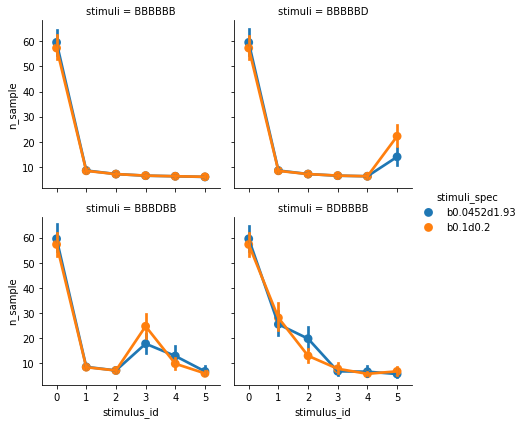

In [28]:
b1d7_df = pd.read_pickle("cache_results/cache_summary/b1d7.pickle")
b1d3_df = pd.read_pickle("cache_results/cache_summary/b1d3.pickle")
b1d15_df = pd.read_pickle("cache_results/cache_summary/b1d15.pickle")
b1d18_df = pd.read_pickle("cache_results/cache_summary/b1d18.pickle")

main_df = pd.concat([b1d3_df, b1d7_df, b1d15_df, b1d18_df])
main_df = main_df[main_df["stimuli"].isin(["BBBBBB", "BBBBBD", "BDBBBB", "BBBDBB"])]

counts = main_df.groupby(['j_i', "batch_id", "stimuli", "stimulus_id", "stimuli_spec"], as_index=False).count()
counts["n_sample"] = counts["EIG"]

#counts

counts['stimulus_id'] = counts['stimulus_id'].astype('category')



# plot everything together
sp = sns.FacetGrid(counts, col = "stimuli",  col_wrap = 2,  hue = "stimuli_spec")
sp.map(sns.pointplot, "stimulus_id", "n_sample",errorbar = "ci", dodge = True)
sp.add_legend()
# separate by batch 
#p = sns.FacetGrid(counts, row = "batch_id")
#p.map(sns.pointplot, "stimulus_id", "n_sample", errorbar = "ci")

In [184]:
counts_last = counts[counts["stimuli"].isin(["BD"])]
#counts_last = counts_last[counts_last["j_i"].isin([1, 8, 13])]

counts_last = counts_last[counts_last["stimulus_id"].isin([1])]
counts_last

sp = sns.FacetGrid(counts_last, col = "j_i", col_wrap=3, 
                 sharey = False, sharex = False)
sp.map(sns.pointplot, "stimulus_id", "n_sample")

ValueError: Number of rows must be a positive integer, not 0

<Figure size 648x0 with 0 Axes>

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.


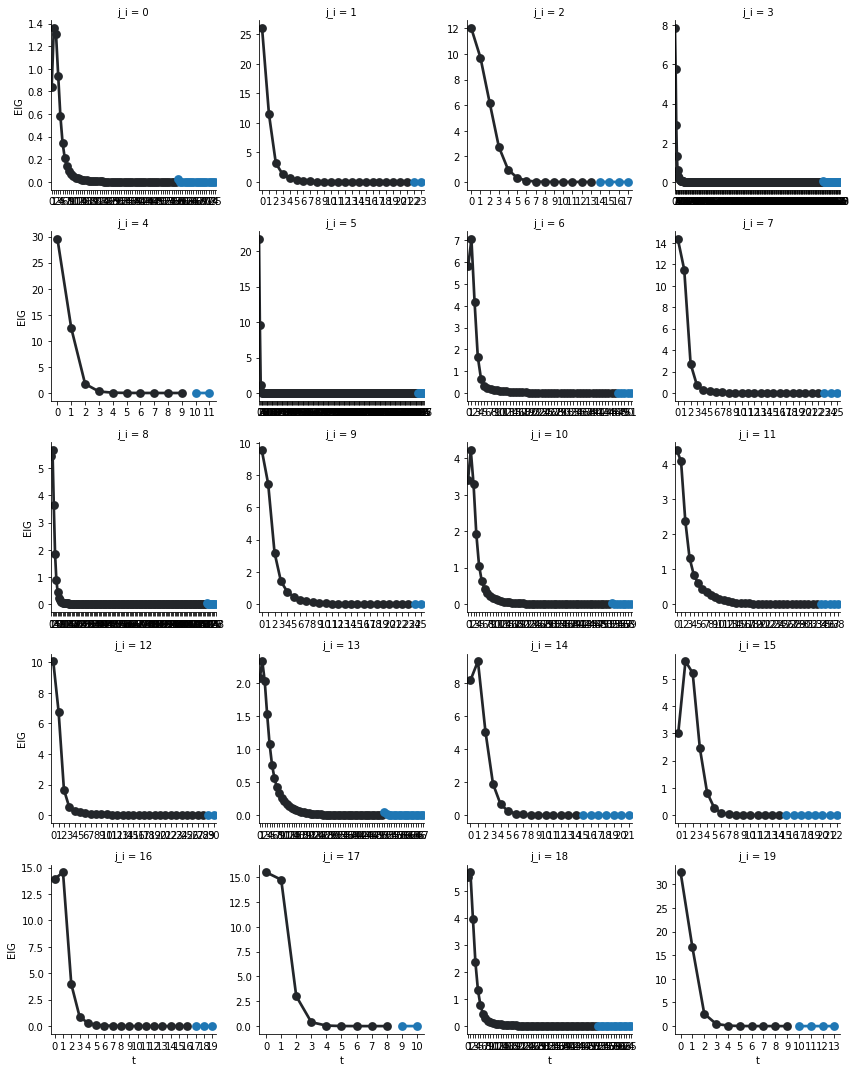

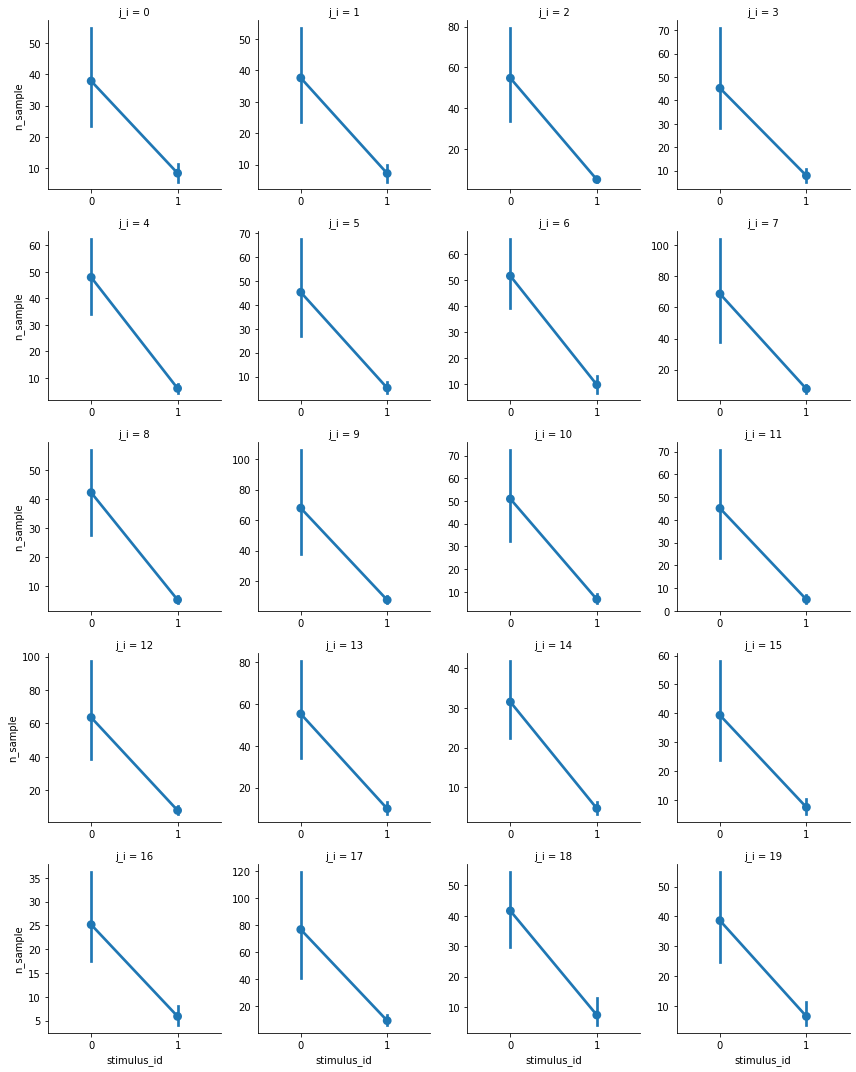

In [185]:
bb_df = pd.read_pickle("cache_results/batch_0_cache_BB.pickle").dropna()

bb_df.index.name = "t"
bb_df.reset_index(inplace = True)
#bb_df_subset = bd_df[bd_df["j_i"].isin([4])]
#bb_df_subset = bb_df_subset[bb_df_subset["stimulus_id"]==0]

bb_eig = sns.FacetGrid(bb_df, col = "j_i", col_wrap=4, sharex=False, sharey=False)
bb_eig.map(sns.pointplot, "t", "EIG", "stimulus_id")


#counts = bb_df_subset.groupby(['j_i', "stimulus_id"], as_index=False).count()
#counts["n_sample"] = counts["EIG"]
#counts

#sns.pointplot(data=bd_df_subset, x = "t", y = "EIG", errorbar = "ci")

sp = sns.FacetGrid(counts, col = "j_i", col_wrap=4, 
                 sharey = False, sharex = False)
sp.map(sns.pointplot, "stimulus_id", "n_sample")




In [186]:
bb_df = pd.read_pickle("cache_results/batch_0_cache_BB.pickle").dropna()
#bb_df_subset = bb_df[bb_df["j_i"] == 10]
#bb_df_subset
bb_df[bb_df["EIG"] <= 0.0001]

,stimulus_id,EIG,Look_away,j_i
57,0,0.000095,True,0
75,1,0.000096,True,0
21,0,0.00007,True,1
23,1,0.00005,True,1
13,0,0.000046,True,2
17,1,0.000016,True,2
232,0,0.000098,True,3
259,1,0.0001,True,3
9,0,0.000076,True,4
11,1,0.00002,True,4


In [124]:
bb_df = pd.read_pickle("cache_results/batch_0_cache_BB.pickle").dropna()
bd_df = pd.read_pickle("cache_results/batch_0_cache_BD.pickle").dropna()
bb_df.index.name = 't'
bb_df.reset_index(inplace=True)
bd_df.index.name = "t"
bd_df.reset_index(inplace=True)

pd.set_option('display.max_rows', None)

bb_df

#bb_df.groupby(["stimulus_id",  "j_i"], as_index=False).count()



#bd_df_j18 = bd_df[bd_df["j_i"] == 18]
#bd_df_j18

,t,stimulus_id,EIG,Look_away,j_i
0,0,0,26.860437,False,0
1,1,0,17.819875,False,0
2,2,0,3.421078,False,0
3,3,0,0.614966,False,0
4,4,0,0.130565,False,0
5,5,0,0.030565,False,0
6,6,0,0.007514,False,0
7,7,0,0.001899,False,0
8,8,0,0.000488,False,0
9,9,0,0.000127,False,0
